**Import & Loading Cleaned Prices**

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [19]:
prices = pd.read_csv("../data/basket_prices.csv", index_col=0, parse_dates=True)
prices = prices.ffill()
prices = prices.loc[~prices.duplicated()]
prices.head()

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2015-01-02,24.237556,15.4260,26.296133,77.969337,39.858459
2015-01-05,23.554739,15.1095,25.795088,76.717064,39.491913
2015-01-06,23.556961,14.7645,25.158482,75.683426,38.912289
2015-01-07,23.887280,14.9210,25.084486,75.683426,39.406681
2015-01-08,24.805080,15.0230,25.171888,77.700989,40.565964


**JOHANSEN COINTEGRATION TEST AND Extract first COINTEGRATING VECTOR (WEIGHTS)**

In [20]:
arr = prices.values # Johansen needs a numpy array with columns = series
# det_order -> no deterministic terms, k_ar_diff ~ lag order for VAR differences (try 1..5)
jres = coint_johansen(arr, det_order=0, k_ar_diff=1) 
# First cointegrating vector (eigenvector corresponding to smallest eigenvalue)
cj_vector = jres.evec[:, 0]  # length = number of assets
# normalize weights so sum of absolute weights = 1 for interpretability
cj_weights = cj_vector / np.sum(np.abs(cj_vector))


In [21]:
weights_df = pd.Series(cj_weights, index=prices.columns)
print("Johansen cointegrating vector (normalized):")
print(weights_df)

Johansen cointegrating vector (normalized):
AAPL     0.014951
AMZN    -0.062103
GOOGL   -0.663455
META     0.051216
MSFT     0.208274
dtype: float64


**Constructing the SPREAD & Plotting**

In [16]:
spread = prices.dot(cj_weights) # linear combination with weights
spread = pd.Series(spread, index=prices.index, name="spread")

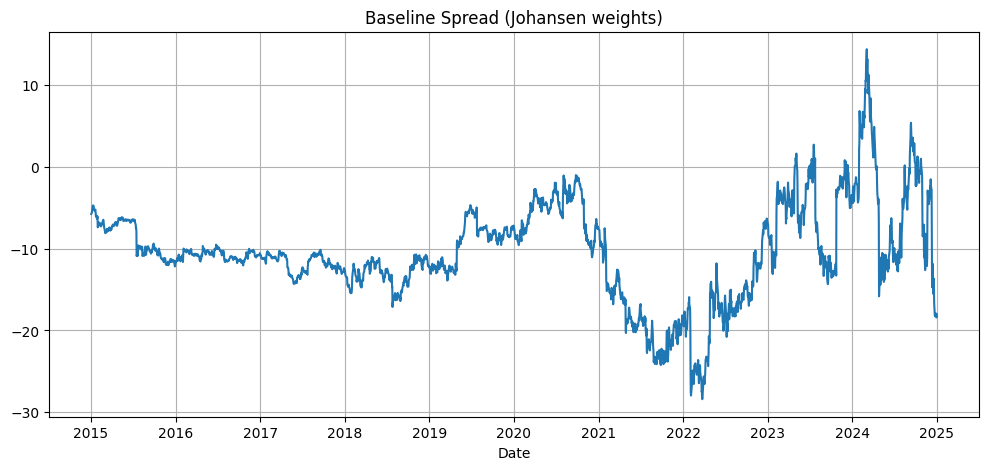

In [17]:
plt.figure(figsize=(12,5))
plt.plot(spread)
plt.title("Baseline Spread (Johansen weights)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

**Computing z-score of spread (using rolling mean/std)**

In [22]:
lookback = 60  # days for rolling mean/std, tuneable
spread_mean = spread.rolling(window=lookback, min_periods=20).mean()
spread_std = spread.rolling(window=lookback, min_periods=20).std()
zscore = (spread - spread_mean) / spread_std

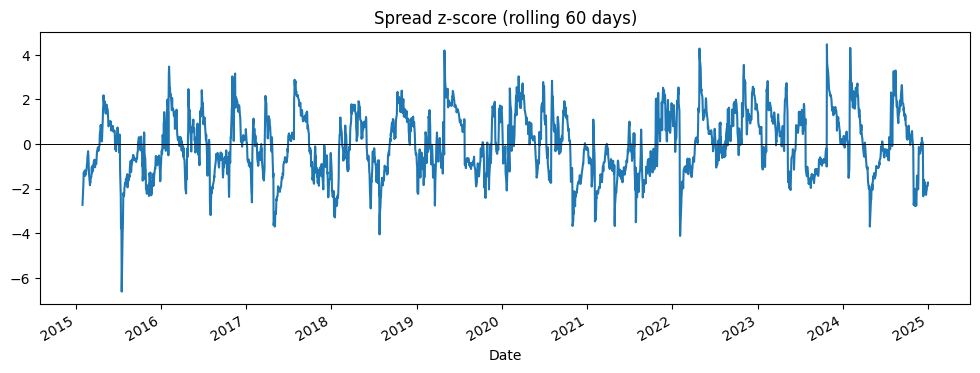

In [25]:
plt.figure(figsize=(12,4))
zscore.plot()
plt.axhline(0, color='black', linewidth=0.7)
plt.title("Spread z-score (rolling {} days)".format(lookback))
plt.show()

**Half-life Estimation**

In [26]:
# Half-life from autoregression: 
#delta_s = a + b*s_lag + eps  => halflife = -ln(2)/b
s = spread.dropna()
s_lag = s.shift(1).dropna()
delta_s = s.diff().dropna()

In [27]:
# align
s_lag = s_lag.loc[delta_s.index]
X = sm.add_constant(s_lag.values)
model = OLS(delta_s.values, X).fit()
b = model.params[1]
halflife = -np.log(2) / b if b < 0 else np.nan  # if b >= 0, not mean-reverting
print(f"Estimated mean-reversion coefficient b = {b:.6f}")
print(f"Estimated half-life (days) = {halflife:.2f}")

Estimated mean-reversion coefficient b = -0.009387
Estimated half-life (days) = 73.84


**Simple mean-reversion trading rules & backtest**

In [32]:
entry_z = 2.0
exit_z = 0.5
zlook = 20

z = (spread - spread.rolling(zlook).mean()) / spread.rolling(zlook).std()
z = z.dropna()

# signals series: 1 => long spread, -1 => short spread, 0 => flat
positions = pd.Series(index=z.index, dtype=float)
pos = 0.0

for t in z.index:
    if pos == 0:
        if z.loc[t] > entry_z:
            pos = -1.0  # short spread
        elif z.loc[t] < -entry_z:
            pos = 1.0   # long spread
    elif pos == 1.0:
        if z.loc[t] >= -exit_z:
            pos = 0.0
    elif pos == -1.0:
        if z.loc[t] <= exit_z:
            pos = 0.0
    positions.loc[t] = pos

# forward-fill positions (position held until changed)
positions = positions.ffill().fillna(0.0)

# compute daily PnL: position * daily change in spread
spread_ret = spread.pct_change().loc[positions.index]  # percent change
# but for spread PnL better use absolute changes since spread is in price units:
spread_diff = spread.diff().loc[positions.index]

pnl = positions.shift(1).fillna(0.0) * (-spread_diff)  
# Note: If you LONG the spread, you profit when spread increases -> pnl = position * spread_diff
# Here we define positions as long=1 meaning long spread => pnl = position * spread_diff
# We used -spread_diff to align with sign convention if your weights represent short/long basket. 
# If sign becomes confusing, inspect small window and flip sign accordingly.

cum_pnl = pnl.cumsum()


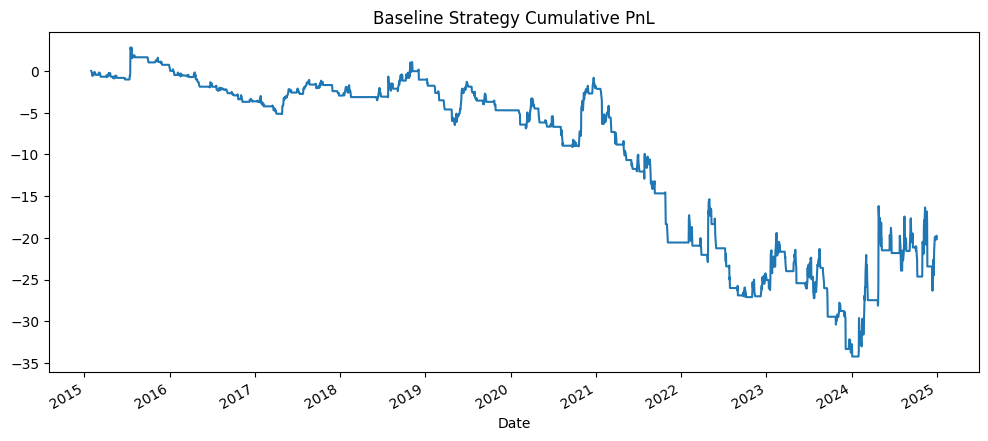

In [33]:
plt.figure(figsize=(12,5))
cum_pnl.plot()
plt.title("Baseline Strategy Cumulative PnL")
plt.show()

**Performance metrics: daily returns, annualized Sharpe, max drawdown**

In [36]:
# Convert PnL to returns by dividing by notional. We'll use notional = mean(abs(weights)*price) scale or simple approach:
notional = 1_000_000  # assume $1M notional to scale PnL -> this is arbitrary and cancels out for Sharpe if constant
daily_returns = pnl / notional

# annualized Sharpe (assume 252 trading days)
avg = daily_returns.mean()
std = daily_returns.std()
sharpe_annual = (avg / std) * np.sqrt(252) if std != 0 else np.nan

# cumulative returns
cum_returns = (1 + daily_returns).cumprod() - 1

# max drawdown
rolling_max = cum_pnl.cummax()
drawdown = (cum_pnl - rolling_max)
max_drawdown = drawdown.min()


In [37]:
print(f"Daily avg return: {avg:.6e}")
print(f"Daily std: {std:.6e}")
print(f"Annualized Sharpe: {sharpe_annual:.3f}")
print(f"Max Drawdown (abs PnL): {max_drawdown:.2f}")

Daily avg return: -8.060207e-09
Daily std: 5.348668e-07
Annualized Sharpe: -0.239
Max Drawdown (abs PnL): -37.04


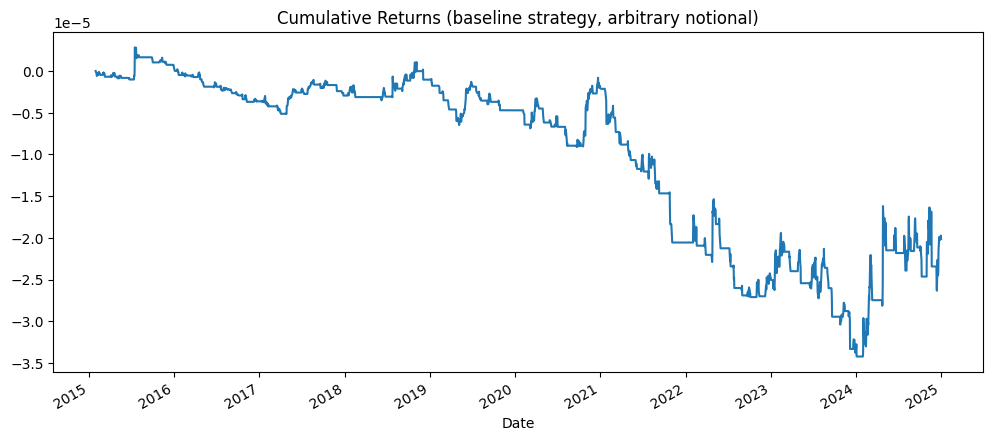

In [38]:
plt.figure(figsize=(12,5))
cum_returns.plot()
plt.title("Cumulative Returns (baseline strategy, arbitrary notional)")
plt.show()

In [39]:
# debug print to inspect trades and signals
df = pd.DataFrame({
    "price_spread": spread,
    "zscore": z,
    "position": positions,
    "spread_diff": spread.diff(),
    "pnl": pnl
}).loc[positions.abs() > 0].head(40)  # show first 40 rows where position non-zero

df.head(20)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [40]:
# save positions and pnl
out = pd.DataFrame({
    "spread": spread,
    "zscore": z,
    "position": positions,
    "pnl": pnl,
    "cum_pnl": cum_pnl
}).dropna()

out.to_csv("../results/baseline_backtest.csv")
print("Saved baseline backtest to ../results/baseline_backtest.csv")

Saved baseline backtest to ../results/baseline_backtest.csv
